- https://www.kaggle.com/cdeotte/lstm-feature-impor
- https://stats.stackexchange.com/questions/191855/variable-importance-in-rnn-or-lstm

In [4]:
# pip install optuna

In [1]:
import numpy as np, os
import pandas as pd

# import optuna

# https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/274717 
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold

from IPython.display import display

In [2]:
import random    
seed_num = 42
random.seed(seed_num)

x = np.load('/project/LSH/x_(7727,10,4069).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6182, 10, 4069), (6182,), (1545, 10, 4069), (1545,))

--------------- > Fold 1 < ---------------
 Predicting test data...
 Computing LSTM feature importance...


  0%|          | 0/4069 [00:00<?, ?it/s]

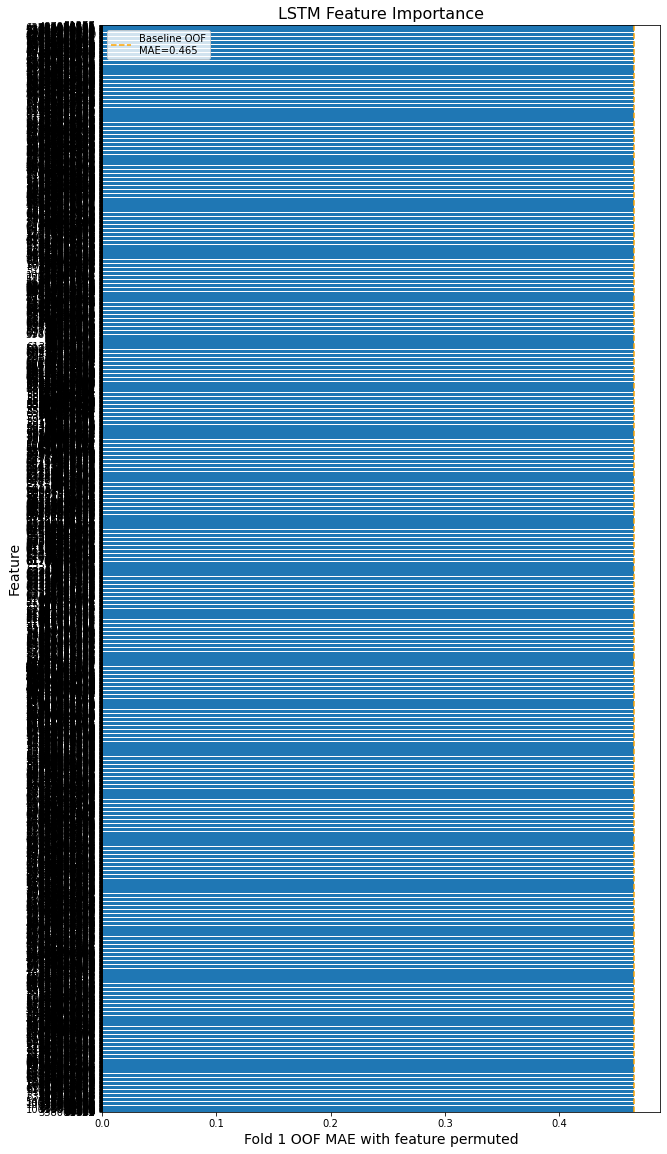

In [17]:
a = pd.read_csv('total_data.csv')
COLS = list(a['ITEMID'].sort_values().unique())

DEBUG = False
TRAIN_MODEL = False 
INFER_TEST = True
ONE_FOLD_ONLY = True
COMPUTE_LSTM_IMPORTANCE = True

EPOCH = 300
BATCH_SIZE = 1024
NUM_FOLDS = 10

# GET GPU STRATEGY
gpu_strategy = tf.distribute.get_strategy()

with gpu_strategy.scope():
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2021)
    test_preds = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
        K.clear_session()
        
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        X_train, X_valid = X_train[train_idx], X_train[test_idx]
        y_train, y_valid = y_train[train_idx], y_train[test_idx]
        
        checkpoint_filepath = f"folds{fold}.hdf5"
        if TRAIN_MODEL:
            model = keras.models.Sequential([
                keras.layers.InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])),
                keras.layers.LSTM(128, activation='hard_sigmoid', return_sequences=True),
                keras.layers.LSTM(64, activation='hard_sigmoid', return_sequences=True),
                keras.layers.Dropout(0.2),
                keras.layers.LSTM(64, activation='hard_sigmoid', return_sequences=True),
                keras.layers.LSTM(32, activation='hard_sigmoid', return_sequences=False),
                keras.layers.Dropout(0.2),
                keras.layers.Dense(1, activation='sigmoid')
            ])
            model.compile(optimizer="adam", loss="binary_crossentropy")

            lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
            es = EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode="min", restore_best_weights=True)
            sv = keras.callbacks.ModelCheckpoint(
                checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                save_weights_only=False, mode='auto', save_freq='epoch',
                options=None
            )
            model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr, es, sv])
            
        else:
            model = keras.models.load_model('./'+checkpoint_filepath)
            

        if INFER_TEST:
            print(' Predicting test data...')
            test_preds.append(model.predict(X_test,verbose=0).reshape(-1, 1))
                    
        if COMPUTE_LSTM_IMPORTANCE:
            results = []
            print(' Computing LSTM feature importance...')
            
            # COMPUTE BASELINE (NO SHUFFLE)
            oof_preds = model.predict(X_test, verbose=0)               ### X_valid => X_test
            baseline_mae = np.mean(np.abs( oof_preds-y_test ))
            results.append({'feature':'BASELINE','mae':baseline_mae})           

            for k in tqdm(range(len(COLS))):
                
                # SHUFFLE FEATURE K
                save_col = X_test[:,:,k].copy()
                np.random.shuffle(X_test[:,:,k])
                        
                # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
                oof_preds = model.predict(X_test, verbose=0)
                mae = np.mean(np.abs( oof_preds-y_test ))
                results.append({'feature':COLS[k],'mae':mae})
                X_test[:,:,k] = save_col
         
            # DISPLAY LSTM FEATURE IMPORTANCE
            print()
            df = pd.DataFrame(results)
            df = df.sort_values('mae')
            plt.figure(figsize=(10,20))
            plt.barh(np.arange(len(COLS)+1),df.mae)
            plt.yticks(np.arange(len(COLS)+1),df.feature.values)
            plt.title('LSTM Feature Importance',size=16)
            plt.ylim((-1,len(COLS)+1))
            plt.plot([baseline_mae,baseline_mae],[-1,len(COLS)+1], '--', color='orange',
                     label=f'Baseline OOF\nMAE={baseline_mae:.3f}')
            plt.xlabel(f'Fold {fold+1} OOF MAE with feature permuted',size=14)
            plt.ylabel('Feature',size=14)
            plt.legend()
            plt.show()
                               
            # SAVE LSTM FEATURE IMPORTANCE
            df = df.sort_values('mae',ascending=False)
            df.to_csv(f'lstm_feature_importance_fold_{fold+1}.csv',index=False)
                               
        # ONLY DO ONE FOLD
        if ONE_FOLD_ONLY: break

In [18]:
results

[{'feature': 'BASELINE', 'mae': 0.4654071774615564},
 {'feature': 0, 'mae': 0.4654071806114844},
 {'feature': 50803, 'mae': 0.4654071768672304},
 {'feature': 50804, 'mae': 0.46540712147604435},
 {'feature': 50805, 'mae': 0.4654071774813673},
 {'feature': 50806, 'mae': 0.4654071755696185},
 {'feature': 50808, 'mae': 0.4654071456353975},
 {'feature': 50809, 'mae': 0.4654071614444699},
 {'feature': 50811, 'mae': 0.4654071691508974},
 {'feature': 50813, 'mae': 0.4654071400190165},
 {'feature': 50814, 'mae': 0.4654071774615564},
 {'feature': 50818, 'mae': 0.46540712303119747},
 {'feature': 50820, 'mae': 0.46540712759760244},
 {'feature': 50821, 'mae': 0.46540709799026075},
 {'feature': 50822, 'mae': 0.46540716795233994},
 {'feature': 50824, 'mae': 0.4654071738856948},
 {'feature': 50852, 'mae': 0.4654071774912727},
 {'feature': 50853, 'mae': 0.4654071774714619},
 {'feature': 50856, 'mae': 0.4654071774318401},
 {'feature': 50858, 'mae': 0.4654071774615564},
 {'feature': 50861, 'mae': 0.46540

In [19]:
df.sort_values(by='mae',ascending=True)

,feature,mae
13,50821,0.465407
1980,338001702,0.465407
3,50804,0.465407
11,50818,0.465407
12,50820,0.465407
...,...,...
57,50912,0.465407
2293,487980125,0.465407
175,51221,0.465407
49,50902,0.465407


In [3]:
a = pd.read_csv('total_data.csv')
COLS = list(a['ITEMID'].sort_values().unique())

DEBUG = False
TRAIN_MODEL = True
INFER_TEST = True
ONE_FOLD_ONLY = True
COMPUTE_LSTM_IMPORTANCE = True

EPOCH = 300
BATCH_SIZE = 1024
NUM_FOLDS = 10

# detect and init the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# GET GPU STRATEGY
gpu_strategy = tf.distribute.get_strategy()

with gpu_strategy.scope():
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2021)
    test_preds = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
        K.clear_session()
        
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        X_train, X_valid = X_train[train_idx], X_train[test_idx]
        y_train, y_valid = y_train[train_idx], y_train[test_idx]
        
        checkpoint_filepath = f"folds{fold}.hdf5"
        if TRAIN_MODEL:
            model = keras.models.Sequential([
                keras.layers.InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])),
                keras.layers.LSTM(128, activation='hard_sigmoid', return_sequences=True),
                keras.layers.LSTM(64, activation='hard_sigmoid', return_sequences=True),
                keras.layers.Dropout(0.2),
                keras.layers.LSTM(64, activation='hard_sigmoid', return_sequences=True),
                keras.layers.LSTM(32, activation='hard_sigmoid', return_sequences=False),
                keras.layers.Dropout(0.2),
                keras.layers.Dense(1, activation='sigmoid')
            ])
            model.compile(optimizer="adam", loss="binary_crossentropy")

            lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
            es = EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode="min", restore_best_weights=True)
            sv = keras.callbacks.ModelCheckpoint(
                checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                save_weights_only=False, mode='auto', save_freq='epoch',
                options=None
            )
            model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr, es, sv])
            
        else:
            model = keras.models.load_model('./'+checkpoint_filepath)
            

        if INFER_TEST:
            print(' Predicting test data...')
            test_preds.append(model.predict(X_test,verbose=0).reshape(-1, 1))
                    
        if COMPUTE_LSTM_IMPORTANCE:
            results = []
            print(' Computing LSTM feature importance...')
            
            # COMPUTE BASELINE (NO SHUFFLE)
            oof_preds = model.predict(X_valid, verbose=0)
            baseline_mae = np.mean(np.abs( oof_preds-y_valid ))
            results.append({'feature':'BASELINE','mae':baseline_mae})           

            for k in tqdm(range(len(COLS))):
                
                # SHUFFLE FEATURE K
                save_col = X_valid[:,:,k].copy()
                np.random.shuffle(X_valid[:,:,k])
                        
                # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
                oof_preds = model.predict(X_valid, verbose=0)
                mae = np.mean(np.abs( oof_preds-y_valid ))
                results.append({'feature':COLS[k],'mae':mae})
                X_valid[:,:,k] = save_col
         
            # DISPLAY LSTM FEATURE IMPORTANCE
            print()
            df = pd.DataFrame(results)
            df = df.sort_values('mae')
            plt.figure(figsize=(10,20))
            plt.barh(np.arange(len(COLS)+1),df.mae)
            plt.yticks(np.arange(len(COLS)+1),df.feature.values)
            plt.title('LSTM Feature Importance',size=16)
            plt.ylim((-1,len(COLS)+1))
            plt.plot([baseline_mae,baseline_mae],[-1,len(COLS)+1], '--', color='orange',
                     label=f'Baseline OOF\nMAE={baseline_mae:.3f}')
            plt.xlabel(f'Fold {fold+1} OOF MAE with feature permuted',size=14)
            plt.ylabel('Feature',size=14)
            plt.legend()
            plt.show()
                               
            # SAVE LSTM FEATURE IMPORTANCE
            df = df.sort_values('mae',ascending=False)
            df.to_csv(f'lstm_feature_importance_fold_{fold+1}.csv',index=False)
                               
        # ONLY DO ONE FOLD
#         if ONE_FOLD_ONLY: break

--------------- > Fold 1 < ---------------
Epoch 1/300
6/6 [==============================] - 7s 401ms/step - loss: 0.6755 - val_loss: 0.6662

Epoch 00001: val_loss improved from inf to 0.66617, saving model to folds0.hdf5
Epoch 2/300
6/6 [==============================] - 2s 292ms/step - loss: 0.6741 - val_loss: 0.6631

Epoch 00002: val_loss improved from 0.66617 to 0.66311, saving model to folds0.hdf5
Epoch 3/300
6/6 [==============================] - 2s 310ms/step - loss: 0.6716 - val_loss: 0.6631

Epoch 00003: val_loss improved from 0.66311 to 0.66307, saving model to folds0.hdf5
Epoch 4/300
6/6 [==============================] - 2s 295ms/step - loss: 0.6720 - val_loss: 0.6634

Epoch 00004: val_loss did not improve from 0.66307
Epoch 5/300
6/6 [==============================] - 2s 308ms/step - loss: 0.6716 - val_loss: 0.6635

Epoch 00005: val_loss did not improve from 0.66307
Epoch 6/300
6/6 [==============================] - 2s 306ms/step - loss: 0.6702 - val_loss: 0.6626

Epoch 0

  0%|          | 0/4069 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
results

In [ ]:
df.sort_values(by='mae',ascending=True)

# MAE

In [ ]:
import random    
seed_num = 42
random.seed(seed_num)

x = np.load('/project/LSH/x_(7727,10,4069).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *

seed_num = 42
tf.random.set_seed(seed_num)

lstm = Sequential()
lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1, activation='sigmoid'))

ep = 500
pa = 30
early_stop = EarlyStopping(monitor='val_acc', patience=pa, verbose=1, restore_best_weights=True)
lstm.compile(optimizer= "adam", loss = "binary_crossentropy", metrics=['acc'])

# COLS
a = pd.read_csv('total_data.csv')
COLS = list(a['ITEMID'].sort_values().unique())

results=[]

gpu_strategy = tf.distribute.get_strategy()

with gpu_strategy.scope():
    for k in tqdm(range(len(COLS))):

        # SHUFFLE FEATURE K
        save_col = X_test[:,:,k].copy()
        np.random.shuffle(X_test[:,:,k])

        # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
        oof_preds = lstm.predict(X_test, verbose=0)
        mae = np.mean(np.abs( oof_preds-y_test ))

        results.append({'feature':COLS[k],'mae':mae})
        X_test[:,:,k] = save_col
        
        # DISPLAY LSTM FEATURE IMPORTANCE
        df = pd.DataFrame(results)
        df = df.sort_values('mae')

  0%|          | 0/4069 [00:00<?, ?it/s]

In [8]:
df

,feature,mae
207,51277,0.473350
122,51006,0.474672
57,50912,0.474863
1735,173024256,0.475174
35,50882,0.475275
...,...,...
3271,2735501,0.481784
4999,409198530,0.481784
4428,121054410,0.481784
5791,49502069724,0.481784
